# RTS Data Processing


In [132]:
import json
import tokenize
import numpy as np
import pandas as pd
import os
import re
from itertools import islice


BASE_PATH ='data/RTS_dataset_per_year/{}/{}'
parties = r"\bUDC\b|\bVerts\b|\bPS\b|\bPDC\b|\bPLR\b|\bPES\b|Vert lib|Vert'lib|Verte lib|Vert-lib|Verts lib|Verts-lib|Verte-lib|\bVerte\b|\bVert\b|\bPVL\b"
thematicGeographicals = r'Geneve|Suisse|Valais|Berne|Zurich|Vaud|Fribourg|Neuchatel|Sion|canton|Bale|Vevey|Jura|Montreux|Bienne|GRUYÈRE|Lucerne|TESSIN|Winterthour|Lugano'
thematicThemes = r"DÉBAT|POLITIQUE|LÉGISLATIF|élection|exécutif|conseiller|initiative populaire|votation|référendum|PRÉSIDENT|Vote|CANDIDAT|CAMPAGNE"
YEARS = np.arange(2010, 2020)

In [156]:
#Next, we want to go year by year and find interviews that are with interviews of political parties
party_dict =[]
contributor_dict = []


def read_in(party):   
    
    for year in YEARS:
        if os.path.exists(BASE_PATH.format(year, party)):
            files = [f for f in os.listdir(BASE_PATH.format(year, party))]
            for file in files:
                with open(BASE_PATH.format(year, party)+"/{}".format(file), 'r', encoding='utf-8') as fp:
                    dicts = json.load(fp)
                    for entry in dicts['data']:
                        
                        #Here we will build a dictionary for looking at the contributors of RTS
                        if 'contributors' in entry and 'publicationDate' in entry:
                            contributor_dict.append(entry)
                        
                        #Here we are filtering through the json to build documents for the topic extraction
                        if ('speechToTexts' or 'subTitles' or 'summary') in entry and ('publicationDate' in entry):
                            if 'genres' in entry:
                                if 'Interview' in entry['genres']:
                                    if 'thematicGeographicals' in entry:
                                        for place in entry['thematicGeographicals']:
                                            if re.search(thematicGeographicals,place, re.I):
                                                party_dict.append(entry)
                                    else:
                                        party_dict.append(entry)
                            if 'thematicThemes' in entry and 'thematicGeographicals' in entry:
                                for place in entry['thematicGeographicals']:
                                    if re.search(thematicGeographicals, place, re.I):
                                        for theme in entry['thematicThemes']:
                                            if re.search(thematicThemes, theme, re.I):
                                                party_dict.append(entry)
                            if 'title' in entry:
                                if re.search(parties, entry['title'], re.I):
                                    party_dict.append(entry)
                            if 'thematicPersons' in entry: 
                                for person in entry['thematicPersons']:
                                    if re.search(parties, person, re.I):
                                        party_dict.append(entry)
                            if 'chapters' in entry:
                                for chapter in entry['chapters']:
                                    if 'excerpt' in chapter:
                                        if re.search(parties, chapter['excerpt'], re.I):
                                            party_dict.append(chapter)
                                        if 'thematicThemes' in chapter and 'thematicGeographicals' in chapter:
                                            for place in chapter['thematicGeographicals']:
                                                type(place)
                                                if re.search(thematicGeographicals, place, re.I):
                                                    for theme in chapter['thematicThemes']:
                                                        if re.search(thematicThemes, theme, re.I):
                                                            party_dict.append(chapter)

    return 

#For each party, convert the json into dictionaries

read_in('UDC')
read_in('PDC')
read_in('PS')
read_in('PLR')
read_in('PES')
read_in('PVL')
read_in('Verts')
read_in('Politque')

In [157]:
all_party_topic = pd.DataFrame.from_dict(party_dict)
all_party_contributor = pd.DataFrame.from_dict(contributor_dict)

Above, the json created by querying the RTS archive API for each of the party abbreviations was created into lists of dictionaries. However, it was noted that RTS does not often use the abbreviations for the PES and PVL parties and prefers to use the Verts and Verts libéreaux. Another query was made using the key word "verts" to find more broadcasts for these parties. Below these broadcasts were sorted into either verts or verts libéraux

After reading in the lists of dictionaries, each dictionary is converted to a pandas dataframe. During on our analysis we will look at either the "speechToTexts" or "summary" collumns in order to do some NLP to determine what the key issues each party were discussing and potentially their sentiment about these topics.

This next part is for processing the SpeechtoText portions of the interviews, first we analyse what percentage of our desired groups in fact have the SpeechtoText feature

Below we are cleaning up the data to get ready to make the topic model. A new attribute of year is added, subTitles and speechToTexts are combined with a preference to subtitles and then all duplicate entries are eliminated

In [158]:
#Converting all possible sources of text to one column
year = all_party_topic["publicationDate"].str[:4]
all_party_topic['year'] = year
all_party_topic['text'] = all_party_topic.apply(lambda x: x['subTitles'] if x['speechToTexts'] == None else x['speechToTexts'], axis=1)
all_party_topic['text'] = all_party_topic.apply(lambda x: x['excerpt'] if x['text'] == None else x['text'], axis=1)
all_party_topic['text'] = all_party_topic.apply(lambda x: x['summary'] if x['text'] == None else x['text'], axis=1)

In [159]:
year = all_party_contributor["publicationDate"].str[:4]
all_party_contributor['year'] = year

In [160]:
#Drop any duplicates
print(len(all_party_contributor))
all_party_contributor= all_party_contributor.drop_duplicates('internalArchiveId')
print(len(all_party_contributor))

print(len(all_party_topic))
all_party_topic= all_party_topic.drop_duplicates('internalArchiveId')
print(len(all_party_topic))

31306
17995
25355
6937


Below we will be looking at the number of times a representative from each party is a contributor on RTS.

In [161]:
all_party_contributor = all_party_contributor[['contributors', 'publicationDate', 'year', 'internalArchiveId']]


In [162]:
all_party_contributor = all_party_contributor[['contributors', 'publicationDate', 'year', 'internalArchiveId']]
contributors = all_party_contributor.explode('contributors')
contributors['contributor_role'] = contributors.apply(lambda x: str(x['contributors']['role']) if 'role' in x['contributors'] else x['contributors'] == None, axis=1)


In [175]:
#For each party, look at the contributor and determine if they were from the party or not
contributors['UDC'] = contributors.apply(lambda x: x['contributor_role'] if re.search(r'\bUDC\b', str(x['contributor_role'])) else None, axis =1)
contributors['PDC'] = contributors.apply(lambda x: x['contributor_role'] if re.search(r'\bPDC\b', str(x['contributor_role'])) else None, axis =1)
contributors['PS'] = contributors.apply(lambda x: x['contributor_role'] if re.search(r'\bPS\b', str(x['contributor_role'])) else None, axis =1)
contributors['PLR'] = contributors.apply(lambda x: x['contributor_role'] if re.search(r'\bPLR\b', str(x['contributor_role'])) else None, axis =1)
contributors['Verts'] = contributors.apply(lambda x: x['contributor_role'] if re.search(r"Verts|Vert|\bPES\b|\bPVL\b", str(x['contributor_role']), re.I) else None, axis =1)
contributors['Verts_Libereux'] = contributors.apply(lambda x: x['Verts'] if re.search(r"Vert lib|Vert'lib|Verte lib|Vert-lib|Verts lib|Verts-lib|Verte-lib|\bPVL\b", str(x['Verts']), re.I) else None, axis =1)
contributors['Verts'] = contributors.apply(lambda x: x['Verts'] if x['Verts_Libereux'] == None else None, axis =1)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B10B2EF9C8>],
      dtype=object)

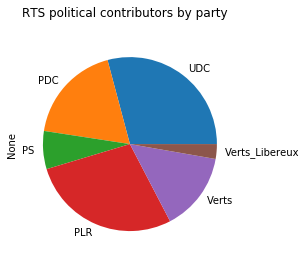

In [178]:
#Create a pie chart of the total political contributors and their respective parties
contributors[['UDC', 'PDC', 'PS', 'PLR', 'Verts', 'Verts_Libereux']].count().plot(kind='pie', subplots=True, title='RTS political contributors by party')


In [177]:
contributors['Verts'].count()

490

We can see from above that the potentially useful columns to analyze the broadcasts would be the summary and speechToTexts. At first we will focus on the speechToTexts

Now we want to look at the words used in the interviews, by both the interviewer and the interviewee using Robin's bag of words method


In [139]:
import re

str_YEARS = ['2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012','2011','2010']


def speech_to_words(speech, year=str_YEARS):
    """
    Return a bag of word sorted by frequency
    
    lang: {'fr','de'}
    username: {'PS Suisse', 'CVP PDC PPD PCD', 'UDC Suisse',
       'Les VERTS suisses 🌻', "Vert'libéraux Suisse", 'PLR Suisse'}
    year: default = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
    
    """
    speech_copy = speech.copy()
    speech_copy = speech_copy[speech_copy['year'].isin(year)]
    speech_copy = speech_copy["text"].astype(str).str.lower()
    
    for text in speech_copy:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))  # deacc=True removes punctuations

In [140]:
import nltk
from nltk.corpus import stopwords
stopwords_fr = stopwords.words('french')
stopwords_fr.extend(['nlocuteur'])

Investigation for using Spacy

In [141]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy

from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [143]:
data_words = list(speech_to_words(all_party_topic))


Creating bigrams

In [144]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=75) # higher threshold fewer phrases.


In [145]:
# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)


Remove stop words, make birgams and lemmatize

In [146]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords_fr] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'fr_core_news_md' model
nlp = spacy.load('fr_core_news_md', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['aller', 'tre', 'vite', 'mise', 'oeuvr', 'initiative', 'renvoi', 'venir', 'annoncer', 'mise', 'pied', 'groupe', 'travail', 'presid', 'tre', 'respecte', 'ancien', 'directeur', 'office_federal', 'justice', 'assez', 'cote', 'autre', 'personne', 'representant', 'initiative', 'representant', 'canton', 'specialiste', 'police', 'groupe', 'faire', 'part', 'proposition', 'ici', 'mois', 'juin', 'fond', 'mandat', 'groupe', 'travail', 'pose', 'question', 'pouvoir', 'mandat', 'creer', 'maintenant', 'possibilite', 'mise', 'oeuvre', 'population', 'voter', 'novembr', 'examiner', 'aussi', 'juridique', 'possible', 'important', 'moment', 'faire', 'projet', 'loi', 'connaître', 'vraiment', 'possibilite', 'differente', 'possibilite', 'aussi', 'juridiquer', 'penser', 'groupe', 'travail', 'arriver', 'trouver', 'consensus', 'groupe', 'travail', 'mandat', 'chercher', 'solution', 'consensu', 'possible', 'falloir', 'voter', 'groupe', 'travail', 'mandat', 'alors', 'present', 'possibilite', 'differente', 'mission

In [147]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 5), (6, 5), (7, 2), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 9), (22, 3), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 2), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 3), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 3), (60, 1), (61, 1), (62, 2), (63, 1), (64, 3), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 3), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 12), (89, 1), (90, 3), (91, 1), (92, 1), (93, 1), (94, 3), (95, 2), (96, 20), (97, 1), (98, 1), (99, 1), (100, 3), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 9), (107, 1), (108, 4), (109, 1), (110, 

Creation of the topic model

In [20]:
#Saving the politique only model
.save('models/RTS_models/all_politique.model')

In [18]:
import os 
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME': r'C:/Users/Isabelle/Downloads/mallet-2.0.8/mallet-2.0.8/'})
mallet_path = 'C:\\Users\\Isabelle\\Downloads\\mallet-2.0.8\\mallet-2.0.8\\bin\\mallet'

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word) # update this path


# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(12,
  [('oui', 0.06346635381463517),
   ('alors', 0.029058467141781504),
   ('bien', 0.025613300880771857),
   ('faire', 0.024159939764310353),
   ('bon', 0.023617118142499432),
   ('dire', 0.022470188586737643),
   ('aller', 0.02211560349507083),
   ('ca', 0.014192158854121067),
   ('meme', 0.011806370274387575),
   ('tout', 0.011412386839202227)]),
 (6,
  [('faire', 0.022891337386018236),
   ('dire', 0.022511398176291792),
   ('donc', 0.017564881926584053),
   ('meme', 0.014328092120645312),
   ('question', 0.01402121814355857),
   ('droit', 0.012589139583820436),
   ('bien', 0.011748889408463876),
   ('aussi', 0.009922258592471358),
   ('tout', 0.009418108487257423),
   ('autre', 0.008497486555997195)]),
 (7,
  [('initiative', 0.041403988250790676),
   ('suisse', 0.03159889270041629),
   ('loi', 0.02525234737650299),
   ('peuple', 0.017384321708566075),
   ('vote', 0.014883740587601344),
   ('dire', 0.013862376467770679),
   ('question', 0.012207062204596842),
   ('oui', 0.0111575

Now we want to find the optimal number of topics by looking at their coherence values

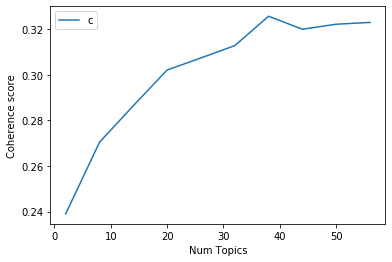

In [152]:
import os 
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME': r'C:/Users/Isabelle/Downloads/mallet-2.0.8/mallet-2.0.8/'})
mallet_path = 'C:\\Users\\Isabelle\\Downloads\\mallet-2.0.8\\mallet-2.0.8\\bin\\mallet'

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    #coherence_values = []
    #model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=44, limit=60, step=6)
# Show graph
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



In [153]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.239
Num Topics = 8  has Coherence Value of 0.2704
Num Topics = 14  has Coherence Value of 0.2865
Num Topics = 20  has Coherence Value of 0.3022
Num Topics = 26  has Coherence Value of 0.3075
Num Topics = 32  has Coherence Value of 0.3129
Num Topics = 38  has Coherence Value of 0.3258
Num Topics = 44  has Coherence Value of 0.3201
Num Topics = 50  has Coherence Value of 0.3223
Num Topics = 56  has Coherence Value of 0.3231


In [155]:
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

[(23,
  '0.024*"faire" + 0.018*"marche" + 0.018*"aussi" + 0.017*"prix" + '
  '0.016*"donc" + 0.015*"suisse" + 0.013*"consommateur" + 0.013*"dire" + '
  '0.012*"alors" + 0.009*"bien" + 0.009*"aller" + 0.009*"sant" + '
  '0.008*"falloir" + 0.008*"produire" + 0.007*"voir"'),
 (24,
  '0.053*"canton" + 0.025*"pourcent" + 0.023*"oui" + 0.021*"dire" + '
  '0.019*"eter" + 0.018*"aussi" + 0.017*"tre" + 0.016*"resultat" + '
  '0.014*"vote" + 0.013*"aller" + 0.013*"meme" + 0.012*"donc" + '
  '0.011*"campagne" + 0.010*"bien" + 0.009*"suisse"'),
 (15,
  '0.021*"faire" + 0.021*"dire" + 0.015*"question" + 0.015*"autre" + '
  '0.014*"aussi" + 0.013*"ecole" + 0.012*"droit" + 0.011*"meme" + '
  '0.011*"falloir" + 0.010*"valeur" + 0.010*"donc" + 0.010*"bien" + '
  '0.010*"tout" + 0.010*"religion" + 0.009*"cas"'),
 (3,
  '0.077*"initiative" + 0.029*"peuple" + 0.027*"suisse" + 0.020*"loi" + '
  '0.020*"initiativ" + 0.020*"vote" + 0.015*"texte" + 0.014*"projet" + '
  '0.013*"votation" + 0.013*"constitution"

In [179]:
#Saving optimal LDA Mallet model
optimal_model.save('models/RTS_models/LDAMallet_40topics.model')